In [83]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [84]:
!pip install pyverilog
!apt-get install graphviz graphviz-dev
!pip install pygraphviz
import pyverilog
import pygraphviz
!apt-get update
!apt-get install -y iverilog


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'libgraphviz-dev' instead of 'graphviz-dev'
graphviz is already the newest version (2.42.2-6ubuntu0.1).
libgraphviz-dev is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 59 not upgraded.
Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy

# Helper Functions:

In [85]:
# AST Helper Functions
import os
from pyverilog.vparser.parser import parse
from pyverilog.vparser.ast import Node
from pygraphviz import AGraph

from IPython.display import Image, display

def parse_verilog_file(file_path):
    ast, _ = parse([file_path])  # Note that parse expects a list of files
    return ast

def ast_to_graph(ast, max_depth=4, filter_node_types=None):
    graph = AGraph(directed=True)

    if filter_node_types is None:
        filter_node_types = set()

    def add_nodes_edges(node, parent_id=None, depth=0):
        if depth > max_depth:
            return
        if type(node).__name__ in filter_node_types:
            return

        node_id = id(node)
        label = type(node).__name__

        # For leaf nodes, add additional info
        if not node.children():
            if hasattr(node, 'value'):
                label += f"\\nvalue: {node.value}"
            elif hasattr(node, 'name'):
                label += f"\\nname: {node.name}"

        graph.add_node(node_id, label=label)

        if parent_id is not None:
            graph.add_edge(parent_id, node_id)

        for child in node.children():
            add_nodes_edges(child, node_id, depth + 1)

    add_nodes_edges(ast)
    return graph

In [86]:
# DFG Helper Functions

from pyverilog.dataflow.dataflow_analyzer import VerilogDataflowAnalyzer
from pyverilog.dataflow.dataflow import (
    DFEvalValue, DFTerminal, DFBranch, DFOperator, DFPartselect, DFPointer, DFConcat,
    DFIntConst, DFFloatConst, DFStringConst, DFConstant
)
import networkx as nx
import matplotlib.pyplot as plt

def extract_nodes(node):
    nodes = []
    if isinstance(node, DFTerminal):
        nodes.append(node.name)
    elif isinstance(node, DFOperator):
        for operand in node.nextnodes:
            nodes.extend(extract_nodes(operand))
    elif isinstance(node, DFBranch):
        nodes.extend(extract_nodes(node.condnode))
        nodes.extend(extract_nodes(node.truenode))
        nodes.extend(extract_nodes(node.falsenode))
    elif isinstance(node, DFConcat):
        for nextnode in node.nextnodes:
            nodes.extend(extract_nodes(nextnode))
    elif isinstance(node, DFPartselect):
        nodes.extend(extract_nodes(node.var))
        nodes.extend(extract_nodes(node.msb))
        nodes.extend(extract_nodes(node.lsb))
    elif isinstance(node, DFPointer):
        nodes.extend(extract_nodes(node.var))
        nodes.extend(extract_nodes(node.ptr))
    elif isinstance(node, (DFIntConst, DFFloatConst, DFStringConst, DFConstant)):
        pass  # Optionally handle constants
    else:
        # Handle other node types or skip
        pass
    return nodes

def dataflows_to_networkx(terms, binddict):
    G = nx.DiGraph()

    for termname, term in terms.items():
        if termname in binddict:
            binds = binddict[termname]
            for bind in binds:
                tree = bind.tree
                src_nodes = extract_nodes(tree)
                for src in src_nodes:
                    if src != termname:
                        G.add_edge(src, termname)
        else:
            continue

    return G

In [99]:
# Embeddings Helper Functions

# Import necessary libraries
from pyverilog.vparser.parser import parse
from pyverilog.vparser.ast import ModuleDef
from pyverilog.dataflow.dataflow_analyzer import VerilogDataflowAnalyzer
from pyverilog.dataflow.dataflow import (
    DFEvalValue, DFTerminal, DFBranch, DFOperator, DFPartselect, DFPointer, DFConcat,
    DFIntConst, DFFloatConst, DFStringConst, DFConstant
)
import networkx as nx
import matplotlib.pyplot as plt

import glob
import os

from sklearn.model_selection import train_test_split
from collections import Counter

# Additional imports for model and visualization
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA

# Function to extract module names from a Verilog file
def get_module_names(verilog_file):
    """
    Parses the Verilog file and returns a list of module names defined within it.

    Args:
        verilog_file (str): Path to the Verilog file.

    Returns:
        list: A list of module names (strings).
    """
    try:
        ast, directives = parse([verilog_file])
    except Exception as e:
        print(f"Error parsing {verilog_file}: {e}")
        return []

    module_names = []
    for desc in ast.description.definitions:
        if isinstance(desc, ModuleDef):
            module_names.append(desc.name)
    return module_names

# Define functions to build the graph (same as before)
def extract_nodes(node):
    nodes = []
    if isinstance(node, DFTerminal):
        nodes.append(node.name)
    elif isinstance(node, DFOperator):
        for operand in node.nextnodes:
            nodes.extend(extract_nodes(operand))
    elif isinstance(node, DFBranch):
        nodes.extend(extract_nodes(node.condnode))
        nodes.extend(extract_nodes(node.truenode))
        nodes.extend(extract_nodes(node.falsenode))
    elif isinstance(node, DFConcat):
        for nextnode in node.nextnodes:
            nodes.extend(extract_nodes(nextnode))
    elif isinstance(node, DFPartselect):
        nodes.extend(extract_nodes(node.var))
        nodes.extend(extract_nodes(node.msb))
        nodes.extend(extract_nodes(node.lsb))
    elif isinstance(node, DFPointer):
        nodes.extend(extract_nodes(node.var))
        nodes.extend(extract_nodes(node.ptr))
    elif isinstance(node, (DFIntConst, DFFloatConst, DFStringConst, DFConstant)):
        pass
    else:
        # Handle other node types or skip
        pass
    return nodes

def dataflows_to_networkx(terms, binddict):
    G = nx.DiGraph()

    for termname, term in terms.items():
        if termname in binddict:
            binds = binddict[termname]
            for bind in binds:
                tree = bind.tree
                src_nodes = extract_nodes(tree)
                for src in src_nodes:
                    if src != termname:
                        G.add_edge(src, termname)
        else:
            continue

    return G

def generate_embedding(graph):
    """
    Generates an embedding for a given graph by extracting multiple graph metrics.

    Args:
        graph (networkx.DiGraph or networkx.Graph): The input graph.

    Returns:
        list: A list of graph feature values.
    """
    if isinstance(graph, nx.DiGraph):
        undirected_graph = graph.to_undirected()
    else:
        undirected_graph = graph

    number_of_nodes = undirected_graph.number_of_nodes()
    number_of_edges = undirected_graph.number_of_edges()

    # Avoid division by zero
    density = nx.density(undirected_graph) if number_of_nodes > 0 else 0
    average_degree = (2 * number_of_edges / number_of_nodes) if number_of_nodes > 0 else 0
    clustering_coeff = nx.average_clustering(undirected_graph) if number_of_nodes > 0 else 0
    number_of_triangles = sum(nx.triangles(undirected_graph).values()) / 3  # Each triangle is counted three times

    return [
        number_of_nodes,
        number_of_edges,
        density,
        average_degree,
        clustering_coeff,
        number_of_triangles
    ]

# Hardware Trojan Detection:

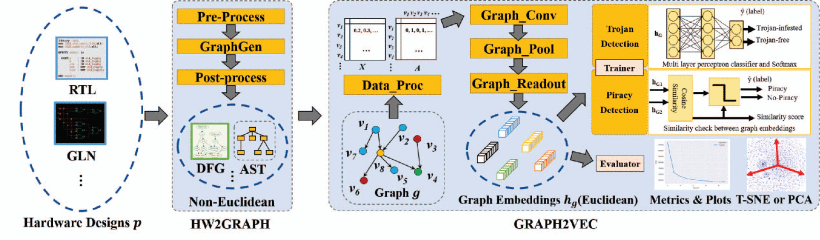

# Abstract Syntax Trees Visualized for Trojan-infected and Trojan-free RS232 Case

We can choose to base our graph representation on an AST. Furthermore, an AST can potentially visualize differences in trojan-injected and trojan-free code. Max depth is set to 4 to and a filter is applied to create a more meaningful visualization.

- Even with a relatively shallow depth of 4, you can see "strange" behavior. In the trojan-free tree, there are "normal" looking always blocks with its respective logic where the trojan-infected tree has repeated assignment blocks.



Generating LALR tables


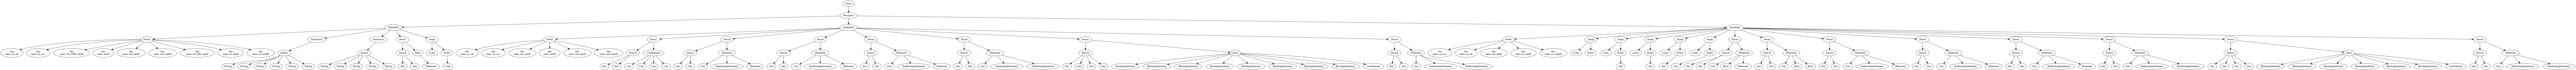

Generating LALR tables


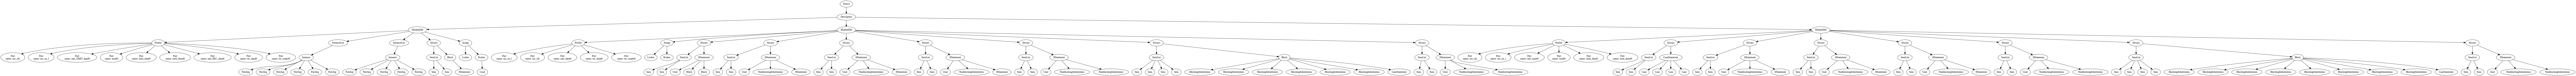

In [88]:
verilog_files = [
    '/content/drive/MyDrive/439_datasets/TJ-RTL-toy/TjIn/RS232-T200/topModule.v',  # Trojan-infected
    '/content/drive/MyDrive/439_datasets/TJ-RTL-toy/TjFree/RS232/topModule.v'      # Trojan-free
]

# Node types to filter out
excluded_node_types = {
    'Identifier',    # Variable names
    'IntConst',
    'FloatConst',
    'StringConst',
    'Paramlist',
    'Decl',
    'Input', 'Output', 'Inout',
    'Wire', 'Reg',

}

for verilog_file in verilog_files:
    # Parse each file individually
    ast = parse_verilog_file(verilog_file)
    graph = ast_to_graph(ast, max_depth=5, filter_node_types=excluded_node_types)
    base_name = os.path.basename(verilog_file).replace('.v', '')
    graph.write(f'{base_name}_ast_graph.dot')
    graph.draw(f'{base_name}_ast_graph.png', prog='dot')
    display(Image(filename=f'{base_name}_ast_graph.png'))


In [89]:
!pip install --upgrade networkx matplotlib


# Data Flow Graph (DFG) Visualized for Trojan-injected and Trojan-free RS232 Case

The data flow graph demonstrates the flow of data as edges and nodes as variables/registers.

Trojan Description
	Trojan trigger is counter inserted in the receiver part of micro-UART core. Trojan counter’s clock is negative of the system clock, and Trojan counter’s enable is comparator over 16 internal signals.

Generating LALR tables
Generating LALR tables


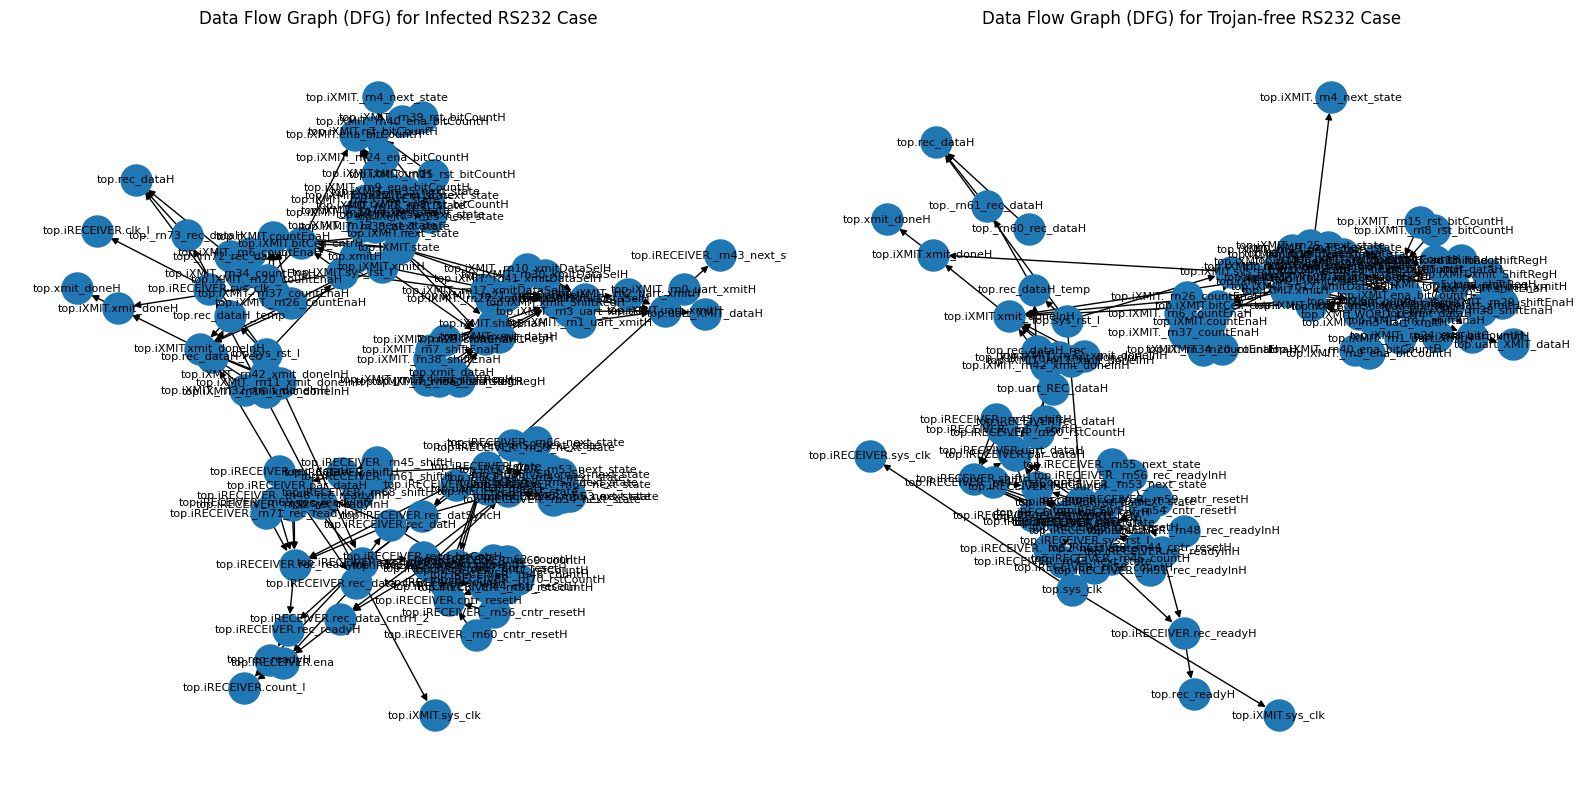

In [90]:

# List of Verilog files to process
verilog_files = [
    '/content/drive/MyDrive/439_datasets/TJ-RTL-toy/TjIn/RS232-T200/topModule.v',  # Trojan-infected
    '/content/drive/MyDrive/439_datasets/TJ-RTL-toy/TjFree/RS232/topModule.v'      # Trojan-free
]

fig, axes = plt.subplots(1, 2, figsize=(16, 8))  # Create a single row of two subplots
titles = ["Data Flow Graph (DFG) for Infected RS232 Case", "Data Flow Graph (DFG) for Trojan-free RS232 Case"]

for idx, verilog_file in enumerate(verilog_files):
    topmodule = 'top'
    analyzer = VerilogDataflowAnalyzer([verilog_file], topmodule)
    try:
        analyzer.generate()
        terms = analyzer.getTerms()
        binddict = analyzer.getBinddict()
        G = dataflows_to_networkx(terms, binddict)

        # Graph Visualization
        ax = axes[idx]
        if G.number_of_nodes() > 0:
            pos = nx.spring_layout(G, k=0.15, seed=42)
            nx.draw(G, pos, with_labels=True, node_size=500, font_size=8, arrows=True, ax=ax)
            ax.set_title(titles[idx])
        else:
            ax.text(0.5, 0.5, "Graph is empty", ha="center", va="center", fontsize=12)
            ax.set_title(titles[idx])
            ax.axis("off")
    except Exception as e:
        print(f"Error processing file {verilog_file}: {e}")
        ax.text(0.5, 0.5, "Error generating graph", ha="center", va="center", fontsize=12)
        ax.set_title(titles[idx])
        ax.axis("off")

plt.tight_layout()
plt.show()


# Converting DFGs to euclidean graph embeddings and then visualizing them using Principle Component Analysis

We generate a DFG for all files in our dataset that have a valid topmodule. We then convert them by taking graph features of the DFG and assigning a weight based on their uniqueness. These features are then reduced to 3 principle components.

In [91]:
base_dir = '/content/drive/MyDrive/439_datasets/TJ-RTL-toy/'

# Paths to TjIn and TjFree directories
tj_in_dir = os.path.join(base_dir, 'TjIn')
tj_free_dir = os.path.join(base_dir, 'TjFree')

# Use glob to find all 'topModule*.v' files recursively in TjIn and TjFree
tjin_files = glob.glob(os.path.join(tj_in_dir, '**/*.v'), recursive=True)
tjfree_files = glob.glob(os.path.join(tj_free_dir, '**/*.v'), recursive=True)

tjin_labels = [1] * len(tjin_files)
tjfree_labels = [0] * len(tjfree_files)

# Split the Data into Training and Test Sets
test_size = 0.4  # 40% for testing, adjust as needed

# Split TjIn files
tjin_train_files, tjin_test_files, tjin_train_labels, tjin_test_labels = train_test_split(
    tjin_files,
    tjin_labels,
    test_size=test_size,
    random_state=42,
    shuffle=True,
    stratify=tjin_labels
)

# Split TjFree files
tjfree_train_files, tjfree_test_files, tjfree_train_labels, tjfree_test_labels = train_test_split(
    tjfree_files,
    tjfree_labels,
    test_size=test_size,
    random_state=42,
    shuffle=True,
    stratify=tjfree_labels
)

filelist = tjin_train_files + tjfree_train_files  # Training dataset
labels = tjin_train_labels + tjfree_train_labels

test_filelist = tjin_test_files + tjfree_test_files  # Test dataset
test_labels = tjin_test_labels + tjfree_test_labels

# Initialize lists to store processed data and corresponding labels
processed_train_graphs = []
processed_train_labels = []
processed_test_graphs = []
processed_test_labels = []

# Initialize counters for successfully processed files
train_success = 0
test_success = 0

# Process each Verilog file individually
# Process Training Files
print("\nProcessing Training Files...")
for verilog_file, label in zip(filelist, labels):
    # Extract module names from the current Verilog file
    print(f"Processing file: {verilog_file}")
    module_names = get_module_names(verilog_file)

    if not module_names:
        print(f"No modules found in Training file: {verilog_file}")
        continue

    print(f"Module names: {module_names}")
    topmodule = module_names[0]

    analyzer = VerilogDataflowAnalyzer([verilog_file], topmodule)
    try:
        analyzer.generate()
        terms = analyzer.getTerms()
        binddict = analyzer.getBinddict()
        G = dataflows_to_networkx(terms, binddict)

        if G.number_of_nodes() > 0:
            processed_train_graphs.append(G)
            processed_train_labels.append(label)
            train_success += 1
        else:
            print(f"Empty graph for Training file: {verilog_file}")
    except Exception as e:
        print(f"Error processing Training file {verilog_file}: {e}")

# Process Test Files
print("\nProcessing Test Files...")
for verilog_file, label in zip(test_filelist, test_labels):
    # Extract module names from the current Verilog file
    module_names = get_module_names(verilog_file)

    if not module_names:
        print(f"No modules found in Test file: {verilog_file}")
        continue
    topmodule = module_names[0]

    analyzer = VerilogDataflowAnalyzer([verilog_file], topmodule)
    try:
        analyzer.generate()
        terms = analyzer.getTerms()
        binddict = analyzer.getBinddict()
        G = dataflows_to_networkx(terms, binddict)

        if G.number_of_nodes() > 0:
            processed_test_graphs.append(G)
            processed_test_labels.append(label)
            test_success += 1
            # print(f"Successfully processed Test file: {verilog_file}")
            # print(f"Module: {topmodule}, Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")
        else:
            print(f"Empty graph for Test file: {verilog_file}")
    except Exception as e:
        print(f"Error processing Test file {verilog_file}: {e}")

# Generate embeddings for Training and Test sets
train_embeddings = []
for G in processed_train_graphs:
    emb = generate_embedding(G)
    if emb is not None:
        train_embeddings.append(emb)
    else:
        print("Failed to generate embedding for a Training graph.")

test_embeddings = []
for G in processed_test_graphs:
    emb = generate_embedding(G)
    if emb is not None:
        test_embeddings.append(emb)
    else:
        print("Failed to generate embedding for a Test graph.")

# Convert embeddings and labels to NumPy arrays
embeddings_train_array = np.array(train_embeddings)
embeddings_test_array = np.array(test_embeddings)
labels_train_array = np.array(processed_train_labels)
labels_test_array = np.array(processed_test_labels)

# Verify embedding counts match labels
assert len(train_embeddings) == len(processed_train_labels), "Mismatch in Training embeddings and labels."
assert len(test_embeddings) == len(processed_test_labels), "Mismatch in Test embeddings and labels."



Processing Training Files...
Processing file: /content/drive/MyDrive/439_datasets/TJ-RTL-toy/TjIn/RS232-T400/topModule.v


Generating LALR tables
Generating LALR tables


Module names: ['top', 'u_rec', 'u_xmit']


Processing file: /content/drive/MyDrive/439_datasets/TJ-RTL-toy/TjIn/RS232-T700/topModule.v


Generating LALR tables
Generating LALR tables


Module names: ['top', 'u_xmit', 'u_rec']


Processing file: /content/drive/MyDrive/439_datasets/TJ-RTL-toy/TjIn/RS232-T500/topModule.v


Generating LALR tables
Generating LALR tables


Module names: ['top', 'u_rec', 'u_xmit']


Processing file: /content/drive/MyDrive/439_datasets/TJ-RTL-toy/TjIn/PIC16F84-T100/topModule2.v


Generating LALR tables


Module names: ['top']


Generating LALR tables


Processing file: /content/drive/MyDrive/439_datasets/TJ-RTL-toy/TjIn/RS232-T300/topModule.v


Generating LALR tables
Generating LALR tables


Module names: ['top', 'u_rec', 'u_xmit']


Processing file: /content/drive/MyDrive/439_datasets/TJ-RTL-toy/TjIn/RS232-T901/topModule.v


Generating LALR tables
Generating LALR tables


Module names: ['top', 'u_rec', 'u_xmit']


Processing file: /content/drive/MyDrive/439_datasets/TJ-RTL-toy/TjIn/PIC16F84-T400/topModule.v


Generating LALR tables
Generating LALR tables


Module names: ['top']


Processing file: /content/drive/MyDrive/439_datasets/TJ-RTL-toy/TjIn/RS232-T800/topModule.v


Generating LALR tables
Generating LALR tables


Module names: ['top', 'u_xmit', 'u_rec']


Processing file: /content/drive/MyDrive/439_datasets/TJ-RTL-toy/TjIn/PIC16F84-T200/topModule.v


Generating LALR tables
Generating LALR tables


Module names: ['top']


Processing file: /content/drive/MyDrive/439_datasets/TJ-RTL-toy/TjIn/RS232-T400/topModule3.v


Generating LALR tables
Generating LALR tables


Module names: ['top', 'u_rec', 'u_xmit']


Processing file: /content/drive/MyDrive/439_datasets/TJ-RTL-toy/TjIn/RS232-T900/topModule.v


Generating LALR tables
Generating LALR tables


Module names: ['top', 'u_rec', 'u_xmit']


Processing file: /content/drive/MyDrive/439_datasets/TJ-RTL-toy/TjIn/RS232-T200/topModule.v


Generating LALR tables
Generating LALR tables


Module names: ['top', 'u_xmit', 'u_rec']


Processing file: /content/drive/MyDrive/439_datasets/TJ-RTL-toy/TjIn/TjInj_Extra/TjIn_T200/risc16f84.v


Generating LALR tables


Module names: ['pic_16f84_core']


Generating LALR tables


Error processing Training file /content/drive/MyDrive/439_datasets/TJ-RTL-toy/TjIn/TjInj_Extra/TjIn_T200/risc16f84.v: Illegal sensitivity list
Processing file: /content/drive/MyDrive/439_datasets/TJ-RTL-toy/TjFree/RS232/topModule3.v


Generating LALR tables
Generating LALR tables


Module names: ['top', 'u_rec', 'u_xmit']


Processing file: /content/drive/MyDrive/439_datasets/TJ-RTL-toy/TjFree/RC6/topModule.v


Generating LALR tables
Generating LALR tables


Module names: ['top', 'rc6_keyex', 'rc6_dpc', 'rc6_rol']


Processing file: /content/drive/MyDrive/439_datasets/TJ-RTL-toy/TjFree/det_1011/topModule.v


Generating LALR tables
Generating LALR tables


Module names: ['top']


Generating LALR tables


Processing file: /content/drive/MyDrive/439_datasets/TJ-RTL-toy/TjFree/PIC16F84/topModule.v


Generating LALR tables


Module names: ['top']


Processing file: /content/drive/MyDrive/439_datasets/TJ-RTL-toy/TjFree/TjFree_Extra/TjFree_T200/risc16f84.v


Generating LALR tables
Generating LALR tables


Error parsing /content/drive/MyDrive/439_datasets/TJ-RTL-toy/TjFree/TjFree_Extra/TjFree_T200/risc16f84.v:  line:1292: before: "/"
No modules found in Training file: /content/drive/MyDrive/439_datasets/TJ-RTL-toy/TjFree/TjFree_Extra/TjFree_T200/risc16f84.v
Processing file: /content/drive/MyDrive/439_datasets/TJ-RTL-toy/TjFree/PIC16F84/topModule2.v


Generating LALR tables


Module names: ['top']


Processing file: /content/drive/MyDrive/439_datasets/TJ-RTL-toy/TjFree/RS232/topModule2.v


Generating LALR tables
Generating LALR tables


Module names: ['top', 'u_rec', 'u_xmit']


Processing file: /content/drive/MyDrive/439_datasets/TJ-RTL-toy/TjFree/RC5/topModule.v


Generating LALR tables
Generating LALR tables


Module names: ['top', 'rc5', 'rc5_dpc', 'rc5_keyex', 'rc5_rol']


Processing file: /content/drive/MyDrive/439_datasets/TJ-RTL-toy/TjFree/syncRAM/topModule2.v


Generating LALR tables
Generating LALR tables


Module names: ['top']


Generating LALR tables


Processing file: /content/drive/MyDrive/439_datasets/TJ-RTL-toy/TjFree/RS232/topModule.v


Generating LALR tables


Module names: ['top', 'u_rec', 'u_xmit']


Processing file: /content/drive/MyDrive/439_datasets/TJ-RTL-toy/TjFree/spi_master/topModule.v


Generating LALR tables
Generating LALR tables


Module names: ['top']


Generating LALR tables


Processing file: /content/drive/MyDrive/439_datasets/TJ-RTL-toy/TjFree/TjFree_Extra/TjFree_T100/risc16f84.v


Generating LALR tables


Error parsing /content/drive/MyDrive/439_datasets/TJ-RTL-toy/TjFree/TjFree_Extra/TjFree_T100/risc16f84.v:  line:1292: before: "/"
No modules found in Training file: /content/drive/MyDrive/439_datasets/TJ-RTL-toy/TjFree/TjFree_Extra/TjFree_T100/risc16f84.v

Processing Test Files...


Generating LALR tables
Generating LALR tables
Generating LALR tables


Error processing Test file /content/drive/MyDrive/439_datasets/TJ-RTL-toy/TjIn/TjInj_Extra/TjIn_T100/risc16f84.v: Illegal sensitivity list


Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables


Error processing Test file /content/drive/MyDrive/439_datasets/TJ-RTL-toy/TjIn/TjInj_Extra/TjIn_T400/risc16f84.v: Illegal sensitivity list


Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables


Error processing Test file /content/drive/MyDrive/439_datasets/TJ-RTL-toy/TjIn/TjInj_Extra/TjIn_T300/risc16f84.v: Illegal sensitivity list


Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables


Error parsing /content/drive/MyDrive/439_datasets/TJ-RTL-toy/TjFree/TjFree_Extra/TjFree_T400/risc16f84.v:  line:1292: before: "/"
No modules found in Test file: /content/drive/MyDrive/439_datasets/TJ-RTL-toy/TjFree/TjFree_Extra/TjFree_T400/risc16f84.v


Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables


Error parsing /content/drive/MyDrive/439_datasets/TJ-RTL-toy/TjFree/TjFree_Extra/TjFree_T300/risc16f84.v:  line:1292: before: "/"
No modules found in Test file: /content/drive/MyDrive/439_datasets/TJ-RTL-toy/TjFree/TjFree_Extra/TjFree_T300/risc16f84.v


Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables


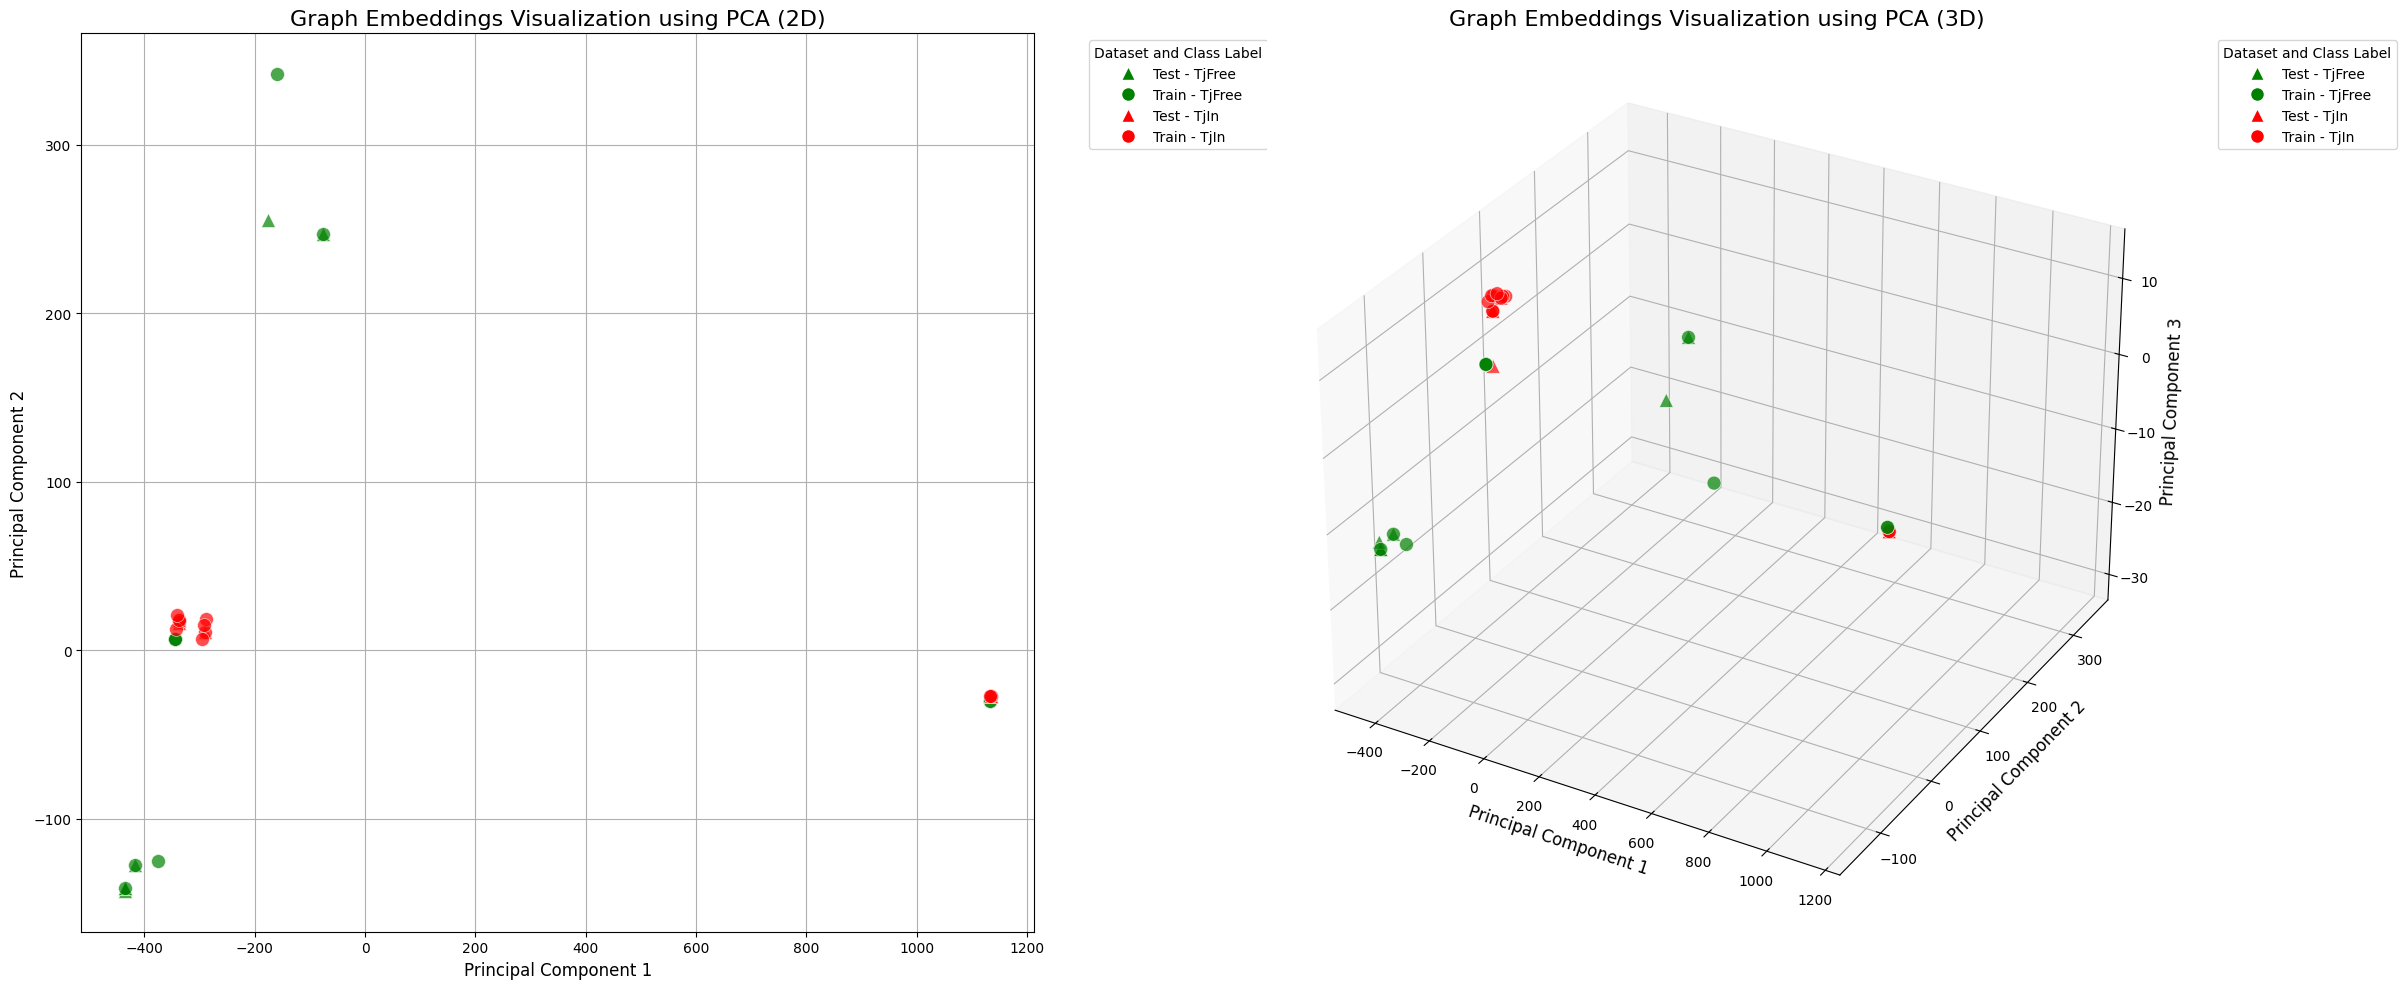

PCA Loadings for 2D PCA:
                             PC1       PC2
Number of Nodes         0.060825  0.551882
Number of Edges         0.476955  0.715890
Density                -0.000038 -0.000586
Average Degree          0.004440 -0.001384
Clustering Coefficient  0.000108 -0.000028
Number of Triangles     0.876809 -0.427697

PCA Loadings for 3D PCA:
                             PC1       PC2       PC3
Number of Nodes         0.060825  0.551882  0.831574
Number of Edges         0.476955  0.715890 -0.509829
Density                -0.000038 -0.000586 -0.005651
Average Degree          0.004440 -0.001384 -0.014867
Clustering Coefficient  0.000108 -0.000028 -0.005373
Number of Triangles     0.876809 -0.427697  0.219719


In [92]:
# Embedding Visualization

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  #3D plotting
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd

# Combine embeddings and labels for visualization
combined_embeddings = np.vstack((embeddings_train_array, embeddings_test_array))
combined_labels = np.concatenate((labels_train_array, labels_test_array))
dataset_type = np.array(['Train'] * len(labels_train_array) + ['Test'] * len(labels_test_array))

# Check if embeddings have at least 3 features
if combined_embeddings.shape[1] < 3:
    print("Feature verification passed")
else:
    # 2D
    pca_2d = PCA(n_components=2, random_state=42)
    embeddings_2d = pca_2d.fit_transform(combined_embeddings)

    # 3D
    pca_3d = PCA(n_components=3, random_state=42)
    embeddings_3d = pca_3d.fit_transform(combined_embeddings)

    # Define colors for each class
    color_map = {0: 'green', 1: 'red'}
    marker_map = {'Train': 'o', 'Test': '^'}

    # Create subplots for 2D and 3D visualizations
    fig = plt.figure(figsize=(24, 10))

    # 2D PCA Scatter Plot
    ax1 = fig.add_subplot(1, 2, 1)
    for label in np.unique(combined_labels):
        for dtype in np.unique(dataset_type):
            idxs = (combined_labels == label) & (dataset_type == dtype)
            ax1.scatter(
                embeddings_2d[idxs, 0],
                embeddings_2d[idxs, 1],
                c=color_map[label],
                marker=marker_map[dtype],
                label=f'{dtype} - {"TjFree" if label == 0 else "TjIn"}',
                s=100,
                alpha=0.7,
                edgecolors='w',
                linewidth=0.5
            )
    ax1.set_title('Graph Embeddings Visualization using PCA (2D)', fontsize=16)
    ax1.set_xlabel('Principal Component 1', fontsize=12)
    ax1.set_ylabel('Principal Component 2', fontsize=12)

    # Legend for 2D Plot
    handles_2d = []
    labels_legend = []
    for label in np.unique(combined_labels):
        for dtype in np.unique(dataset_type):
            handles_2d.append(plt.Line2D([0], [0], marker=marker_map[dtype], color='w',
                                          markerfacecolor=color_map[label], markersize=10, markeredgecolor='w'))
            labels_legend.append(f'{dtype} - {"TjFree" if label == 0 else "TjIn"}')

    ax1.legend(handles_2d, labels_legend, title='Dataset and Class Label', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True)

    # 3D PCA Scatter Plot
    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    for label in np.unique(combined_labels):
        for dtype in np.unique(dataset_type):
            idxs = (combined_labels == label) & (dataset_type == dtype)
            ax2.scatter(
                embeddings_3d[idxs, 0],
                embeddings_3d[idxs, 1],
                embeddings_3d[idxs, 2],
                c=color_map[label],
                marker=marker_map[dtype],
                label=f'{dtype} - {"TjFree" if label == 0 else "TjIn"}',
                s=100,
                alpha=0.7,
                edgecolors='w',
                linewidth=0.5
            )
    ax2.set_title('Graph Embeddings Visualization using PCA (3D)', fontsize=16)
    ax2.set_xlabel('Principal Component 1', fontsize=12)
    ax2.set_ylabel('Principal Component 2', fontsize=12)
    ax2.set_zlabel('Principal Component 3', fontsize=12)

    # Legend for 3D Plot
    handles_3d = []
    for label in np.unique(combined_labels):
        for dtype in np.unique(dataset_type):
            handles_3d.append(plt.Line2D([0], [0], marker=marker_map[dtype], color='w',
                                          markerfacecolor=color_map[label], markersize=10, markeredgecolor='w'))
            labels_legend.append(f'{dtype} - {"TjFree" if label == 0 else "TjIn"}')

    ax2.legend(handles_3d, labels_legend, title='Dataset and Class Label', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

# PCA Loadings for 2D PCA
pca_2d_loadings = pd.DataFrame(pca_2d.components_.T,
                               columns=['PC1', 'PC2'],
                               index=['Number of Nodes', 'Number of Edges', 'Density',
                                      'Average Degree', 'Clustering Coefficient', 'Number of Triangles'])

print("PCA Loadings for 2D PCA:")
print(pca_2d_loadings)

# PCA Loadings for 3D PCA
pca_3d_loadings = pd.DataFrame(pca_3d.components_.T,
                               columns=['PC1', 'PC2', 'PC3'],
                               index=['Number of Nodes', 'Number of Edges', 'Density',
                                      'Average Degree', 'Clustering Coefficient', 'Number of Triangles'])

print("\nPCA Loadings for 3D PCA:")
print(pca_3d_loadings)



## Using *graph embeddings as inputs to different machine learning models

We demonstrate the use of final embeddings by using them as inputs to common ML models including Random Forest Classifiers, Support Vector Machines, Naive Bayes Classifier, and Kth Nearest Neighbor.


Training and evaluating model: Random Forest

Confusion Matrix for Random Forest:
[[7 0]
 [1 6]]

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       1.00      0.86      0.92         7

    accuracy                           0.93        14
   macro avg       0.94      0.93      0.93        14
weighted avg       0.94      0.93      0.93        14

Accuracy for Random Forest: 0.9286

Training and evaluating model: K-Nearest Neighbors

Confusion Matrix for K-Nearest Neighbors:
[[5 2]
 [0 7]]

Classification Report for K-Nearest Neighbors:
              precision    recall  f1-score   support

           0       1.00      0.71      0.83         7
           1       0.78      1.00      0.88         7

    accuracy                           0.86        14
   macro avg       0.89      0.86      0.85        14
weighted avg       0.89      0.86      0.85        14

Accuracy for 

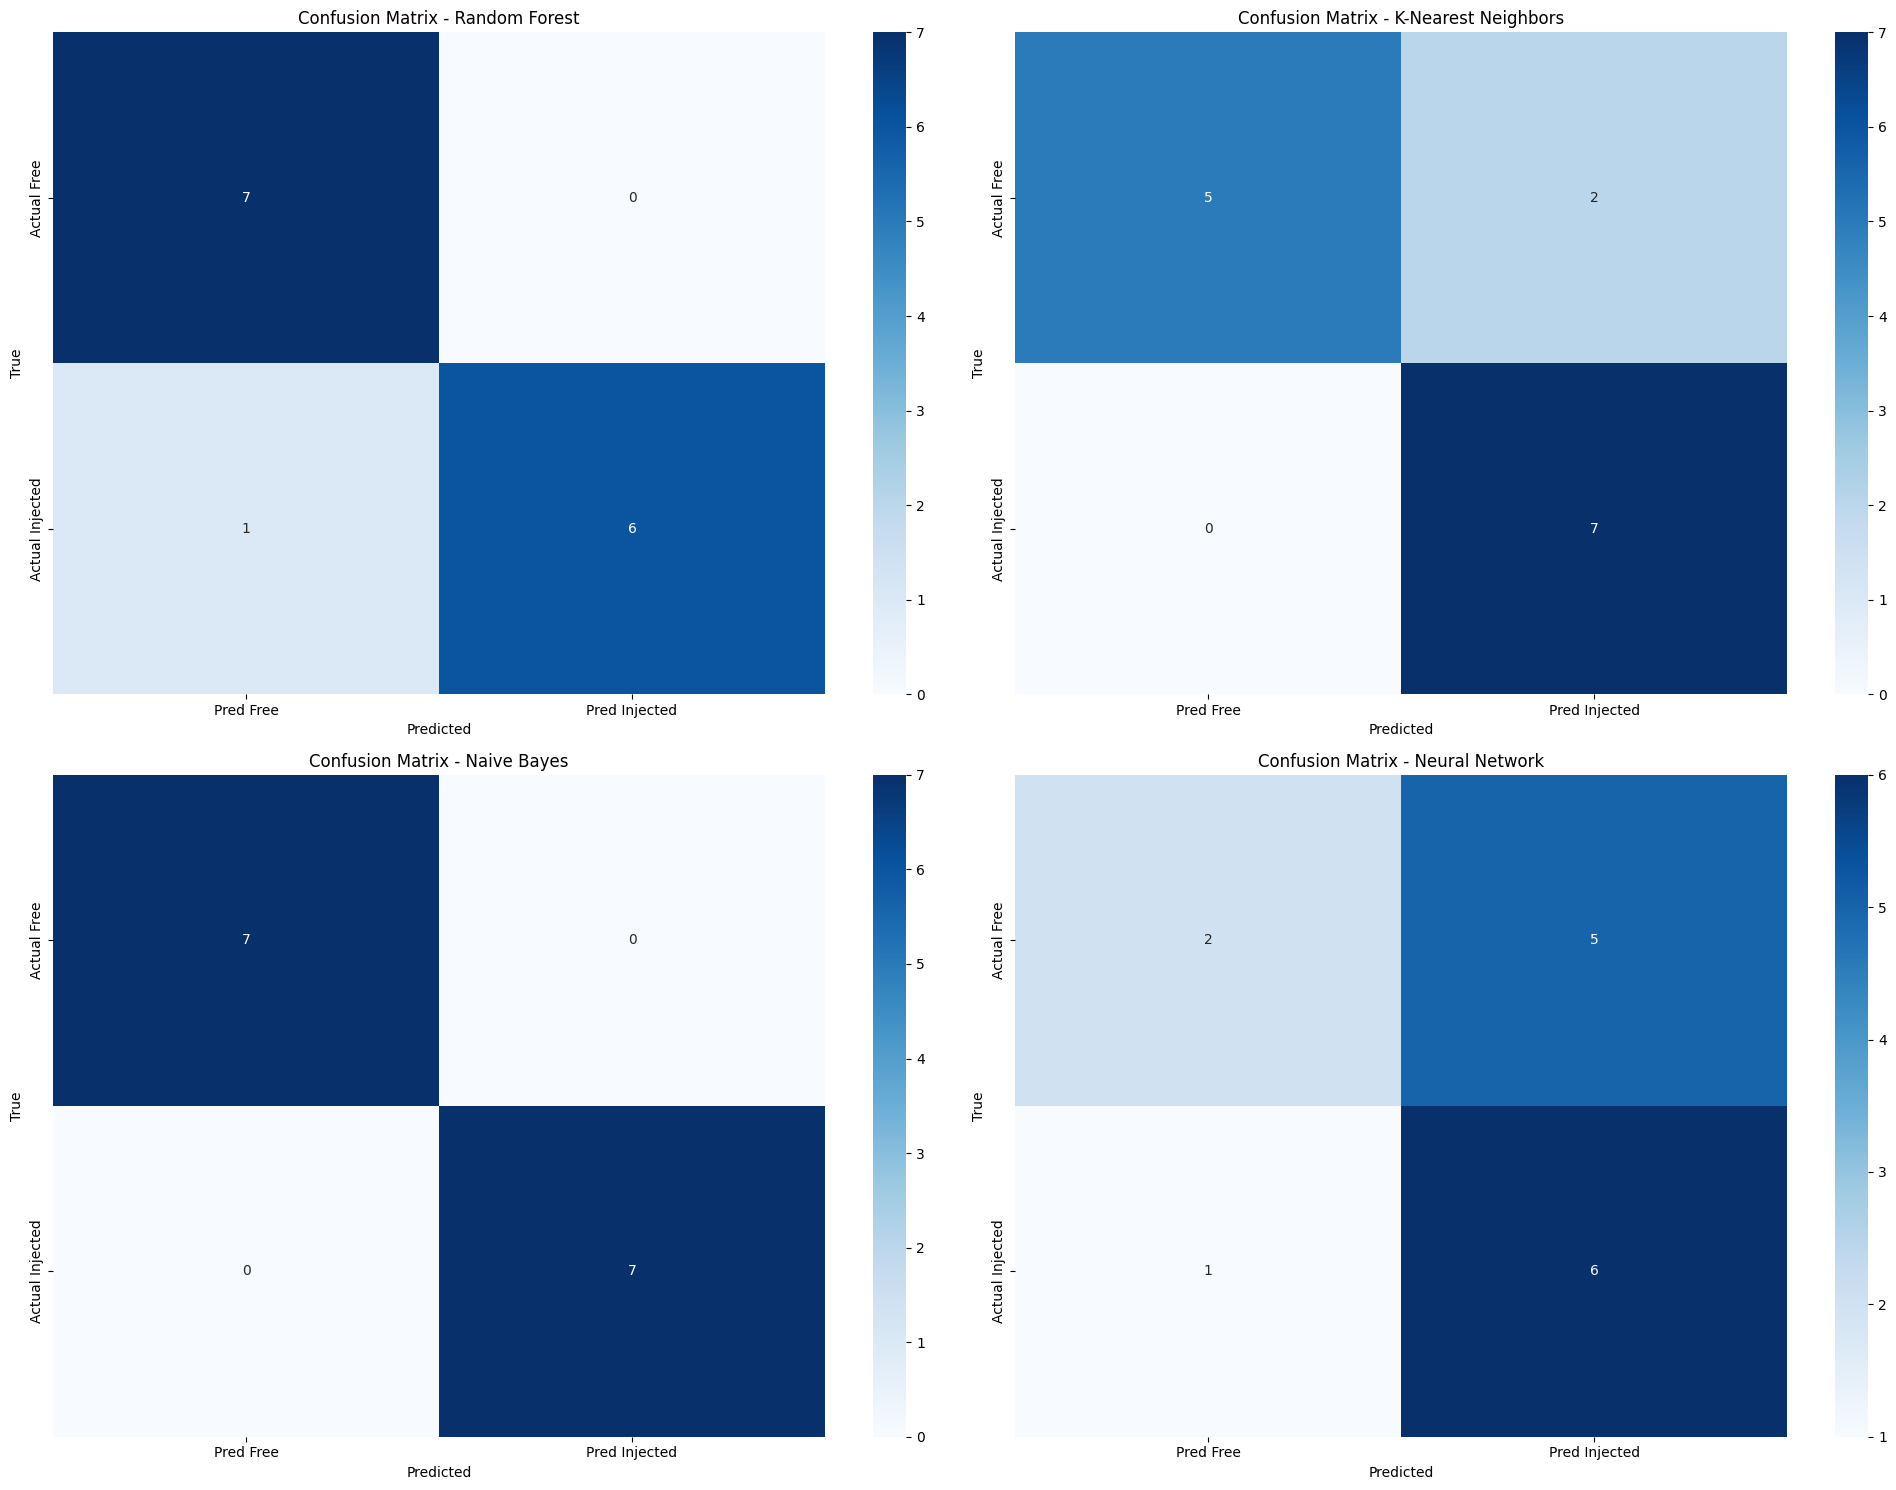


Model Accuracy Scores:
Random Forest: 0.9286
K-Nearest Neighbors: 0.8571
Naive Bayes: 1.0000
Neural Network: 0.5714


In [93]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier


# Define a list of classifiers to evaluate
models = [
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('K-Nearest Neighbors', KNeighborsClassifier()),
    ('Naive Bayes', GaussianNB()),
    ('Neural Network', MLPClassifier(random_state=42, max_iter=1000))
]

fig, axes = plt.subplots(2, 2, figsize=(20, 15))
axes = axes.flatten()
accuracy_scores = []

for idx, (name, model) in enumerate(models):
    print(f"\nTraining and evaluating model: {name}")

    model.fit(train_embeddings, processed_train_labels)
    test_predictions = model.predict(test_embeddings)
    cm = confusion_matrix(processed_test_labels, test_predictions)
    print(f"\nConfusion Matrix for {name}:")
    print(cm)

    # Detailed Classification Report
    print(f"\nClassification Report for {name}:")
    print(classification_report(processed_test_labels, test_predictions))

    # Calculate accuracy
    accuracy = accuracy_score(processed_test_labels, test_predictions)
    accuracy_scores.append((name, accuracy))
    print(f"Accuracy for {name}: {accuracy:.4f}")

    # Plot Confusion Matrix
    ax = axes[idx]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred Free', 'Pred Injected'],
                yticklabels=['Actual Free', 'Actual Injected'],
                ax=ax)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(f'Confusion Matrix - {name}')

plt.tight_layout()
plt.show()

# Display Accuracy Scores
print("\nModel Accuracy Scores:")
for name, acc in accuracy_scores:
    print(f"{name}: {acc:.4f}")



# IP Piracy Detection:

We use our original method of converting our RTL stage verilog files into DFGs and then converting them into embeddings. We then analyze the PCs and classify clusters as "likely piracy" if the graph nodes are within a threshold distance from another graph.


In [100]:
# Paths to IP datasets
ip_netlist_dir = '/content/drive/MyDrive/439_datasets/IP-Netlist-toy/'
ip_rtl_dir = '/content/drive/MyDrive/439_datasets/IP-RTL-toy/'

netlist_files = glob.glob(os.path.join(ip_netlist_dir, '**/*.v'), recursive=True)
rtl_files = glob.glob(os.path.join(ip_rtl_dir, '**/*.v'), recursive=True)

print(f"{len(netlist_files)} Netlist Verilog files.")
print(f"{len(rtl_files)} RTL Verilog files.")

all_files = netlist_files + rtl_files


74 Netlist Verilog files.
21 RTL Verilog files.


In [95]:
# Initialize lists to store embeddings
all_embeddings = []
all_files = netlist_files + rtl_files

# Function to process a single file and extract embedding
def process_verilog_file(verilog_file):
    module_names = get_module_names(verilog_file)
    if not module_names:
        print(f"No modules found in file: {verilog_file}")
        return None
    top_module = module_names[0]  # Assuming the first module is the top module

    try:
        analyzer = VerilogDataflowAnalyzer([verilog_file], top_module)
        analyzer.generate()
        terms = analyzer.getTerms()
        binddict = analyzer.getBinddict()
        G = dataflows_to_networkx(terms, binddict)

        if G.number_of_nodes() == 0:
            print(f"Empty graph for file: {verilog_file}")
            return None

        embedding = generate_embedding(G)
        return embedding
    except Exception as e:
        logging.error(f"Error processing file {verilog_file}: {e}")
        print(f"Error processing file {verilog_file}: {e}")
        return None

# Process all files
print("\nProcessing Verilog Files and Generating Embeddings...")
for file in all_files:
    embedding = process_verilog_file(file)
    if embedding:
        all_embeddings.append(embedding)
    else:
        print(f"Skipping file due to processing issues: {file}")

print(f"\nSuccessfully generated embeddings for {len(all_embeddings)} out of {len(all_files)} files.")



Processing Verilog Files and Generating Embeddings...


Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating LALR tables
Generating 


Successfully generated embeddings for 95 out of 95 files.


In [96]:
from sklearn.preprocessing import StandardScaler
# Convert embeddings to NumPy array
embeddings_array = np.array(all_embeddings)
print(f"Embeddings Array Shape: {embeddings_array.shape}")

# Feature Scaling
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings_array)

# Initialize PCA
pca = PCA(n_components=3, random_state=42)
pca.fit(embeddings_scaled)
embeddings_pca = pca.transform(embeddings_scaled)

Embeddings Array Shape: (95, 6)


In [97]:
from sklearn.metrics import pairwise_distances

# Compute pairwise Euclidean distances
distance_matrix = pairwise_distances(embeddings_pca, metric='euclidean')
upper_tri_indices = np.triu_indices_from(distance_matrix, k=1)
pairwise_distances_values = distance_matrix[upper_tri_indices]
mean_distance = np.mean(pairwise_distances_values)
std_distance = np.std(pairwise_distances_values)

print(f"Mean Pairwise Distance: {mean_distance:.4f}")
print(f"Standard Deviation of Pairwise Distances: {std_distance:.4f}")

# Graphs closer than (mean - 1.56 *std) are considered highly similar
similarity_threshold = mean_distance - 1.56 * std_distance

# Initialize piracy labels

# 1: Piracy, 0: Not Piracy
piracy_labels = np.zeros(embeddings_pca.shape[0], dtype=int)

# Iterate through each graph and check if it has any neighbor within the similarity threshold
for i in range(embeddings_pca.shape[0]):
    # Extract distances for the current graph
    distances = distance_matrix[i]

    # Find indices where distance is less than or equal to the threshold
    similar_indices = np.where((distances <= similarity_threshold) & (distances > 0))[0]

    if similar_indices.size > 0:
        piracy_labels[i] = 1

print(f"\nNumber of Piracy Detected: {np.sum(piracy_labels)} out of {len(piracy_labels)}")

Mean Pairwise Distance: 2.8424
Standard Deviation of Pairwise Distances: 1.7644

Number of Piracy Detected: 16 out of 95


#Using *graph embeddings to analyze potential piracy

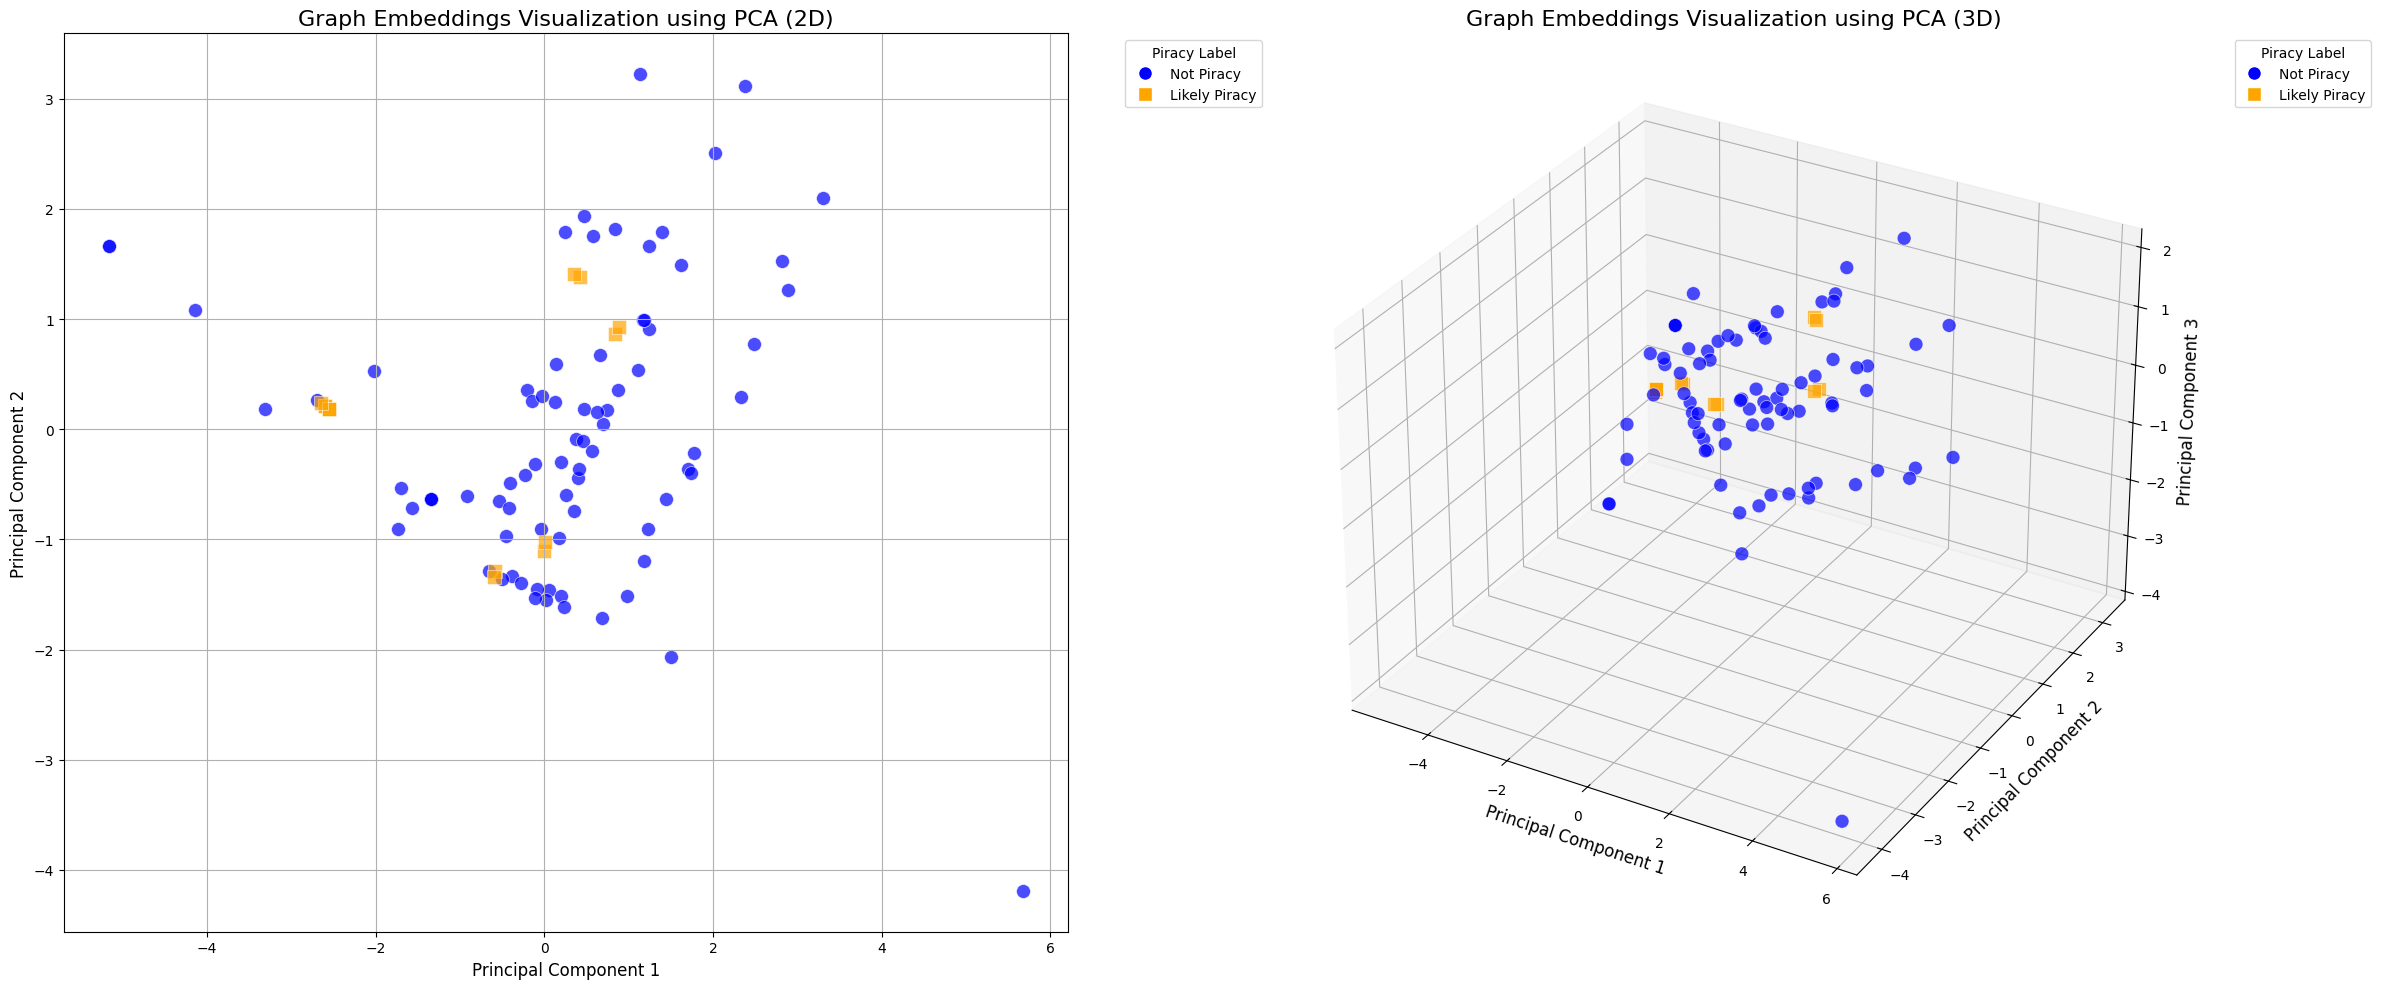

PCA Loadings for 3D PCA:
                             PC1       PC2       PC3
Number of Nodes         0.506081 -0.145364 -0.431949
Number of Edges         0.482472 -0.237994 -0.434781
Density                -0.417338  0.163304 -0.507205
Average Degree          0.328450 -0.419208  0.523511
Clustering Coefficient  0.274607  0.639061  0.291476
Number of Triangles     0.391974  0.558055 -0.090041


In [98]:
# Embedding Visualization with Piracy Labels

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # 3D plotting
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd

# Combine embeddings and labels for visualization
combined_embeddings_pca = embeddings_pca
combined_piracy_labels = piracy_labels
combined_files = all_files

# Define colors based on piracy labels
piracy_color_map = {0: 'blue', 1: 'orange'}  # 0: Not Piracy, 1: Piracy
piracy_marker_map = {0: 'o', 1: 's'}  # 0: Circle, 1: Square

# Create subplots for 2D and 3D visualizations
fig = plt.figure(figsize=(24, 10))

# 2D PCA Scatter Plot
ax1 = fig.add_subplot(1, 2, 1)
for piracy_label in np.unique(combined_piracy_labels):
    idxs = (combined_piracy_labels == piracy_label)
    ax1.scatter(
        combined_embeddings_pca[idxs, 0],
        combined_embeddings_pca[idxs, 1],
        c=piracy_color_map[piracy_label],
        marker=piracy_marker_map[piracy_label],
        label=f'{"Piracy" if piracy_label == 1 else "Not Piracy"}',
        s=100,
        alpha=0.7,
        edgecolors='w',
        linewidth=0.5
    )
ax1.set_title('Graph Embeddings Visualization using PCA (2D)', fontsize=16)
ax1.set_xlabel('Principal Component 1', fontsize=12)
ax1.set_ylabel('Principal Component 2', fontsize=12)

# Legend for 2D Plot
handles_2d = []
labels_legend_2d = []
for piracy_label in np.unique(combined_piracy_labels):
    handles_2d.append(plt.Line2D([0], [0], marker=piracy_marker_map[piracy_label], color='w',
                                  markerfacecolor=piracy_color_map[piracy_label], markersize=10, markeredgecolor='w'))
    labels_legend_2d.append(f'{"Likely Piracy" if piracy_label == 1 else "Not Piracy"}')

ax1.legend(handles_2d, labels_legend_2d, title='Piracy Label', bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True)

# 3D PCA Scatter Plot
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
for piracy_label in np.unique(combined_piracy_labels):
    idxs = (combined_piracy_labels == piracy_label)
    ax2.scatter(
        combined_embeddings_pca[idxs, 0],
        combined_embeddings_pca[idxs, 1],
        combined_embeddings_pca[idxs, 2],
        c=piracy_color_map[piracy_label],
        marker=piracy_marker_map[piracy_label],
        label=f'{"Likely Piracy" if piracy_label == 1 else "Not Piracy"}',
        s=100,
        alpha=0.7,
        edgecolors='w',
        linewidth=0.5
    )
ax2.set_title('Graph Embeddings Visualization using PCA (3D)', fontsize=16)
ax2.set_xlabel('Principal Component 1', fontsize=12)
ax2.set_ylabel('Principal Component 2', fontsize=12)
ax2.set_zlabel('Principal Component 3', fontsize=12)

# Legend for 3D Plot
handles_3d = []
labels_legend_3d = []
for piracy_label in np.unique(combined_piracy_labels):
    handles_3d.append(plt.Line2D([0], [0], marker=piracy_marker_map[piracy_label], color='w',
                                  markerfacecolor=piracy_color_map[piracy_label], markersize=10, markeredgecolor='w'))
    labels_legend_3d.append(f'{"Likely Piracy" if piracy_label == 1 else "Not Piracy"}')

ax2.legend(handles_3d, labels_legend_3d, title='Piracy Label', bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True)

plt.tight_layout()
plt.show()

# PCA Loadings for 3D PCA
pca_loadings = pd.DataFrame(pca.components_.T,
                            columns=['PC1', 'PC2', 'PC3'],
                            index=['Number of Nodes', 'Number of Edges', 'Density',
                                   'Average Degree', 'Clustering Coefficient', 'Number of Triangles'])

print("PCA Loadings for 3D PCA:")
print(pca_loadings)
